# Backpropagation from Scratch

## Introduction

Backpropagation is the cornerstone algorithm for training neural networks. It provides an efficient method to compute gradients of the loss function with respect to each weight in the network by applying the chain rule of calculus systematically from the output layer back to the input layer.

This notebook implements a complete neural network from scratch, demonstrating the mathematical foundations and computational mechanics of backpropagation.

## Mathematical Foundation

### Neural Network Architecture

Consider a feedforward neural network with $L$ layers. For each layer $l$, we define:

- $\mathbf{W}^{(l)}$: Weight matrix connecting layer $l-1$ to layer $l$
- $\mathbf{b}^{(l)}$: Bias vector for layer $l$
- $\mathbf{z}^{(l)}$: Pre-activation (weighted input) at layer $l$
- $\mathbf{a}^{(l)}$: Activation (output) at layer $l$

### Forward Propagation

The forward pass computes the network output through successive transformations:

$$\mathbf{z}^{(l)} = \mathbf{W}^{(l)} \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}$$

$$\mathbf{a}^{(l)} = \sigma(\mathbf{z}^{(l)})$$

where $\sigma$ is the activation function. For the input layer, $\mathbf{a}^{(0)} = \mathbf{x}$.

### Activation Functions

**Sigmoid:**
$$\sigma(z) = \frac{1}{1 + e^{-z}}, \quad \sigma'(z) = \sigma(z)(1 - \sigma(z))$$

**ReLU:**
$$\text{ReLU}(z) = \max(0, z), \quad \text{ReLU}'(z) = \begin{cases} 1 & z > 0 \\ 0 & z \leq 0 \end{cases}$$

**Tanh:**
$$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}, \quad \tanh'(z) = 1 - \tanh^2(z)$$

### Loss Function

For binary classification, we use the binary cross-entropy loss:

$$\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]$$

where $m$ is the number of training examples, $y^{(i)}$ is the true label, and $\hat{y}^{(i)}$ is the predicted probability.

### Backpropagation Algorithm

The key insight of backpropagation is the recursive computation of error terms $\boldsymbol{\delta}^{(l)}$ for each layer.

**Output Layer Error ($l = L$):**
$$\boldsymbol{\delta}^{(L)} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}} = \mathbf{a}^{(L)} - \mathbf{y}$$

**Hidden Layer Error ($l < L$):**
$$\boldsymbol{\delta}^{(l)} = \left( (\mathbf{W}^{(l+1)})^T \boldsymbol{\delta}^{(l+1)} \right) \odot \sigma'(\mathbf{z}^{(l)})$$

where $\odot$ denotes element-wise multiplication.

**Gradient Computation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(l)}} = \frac{1}{m} \boldsymbol{\delta}^{(l)} (\mathbf{a}^{(l-1)})^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(l)}} = \frac{1}{m} \sum_{i=1}^{m} \boldsymbol{\delta}^{(l,i)}$$

### Parameter Update (Gradient Descent)

$$\mathbf{W}^{(l)} \leftarrow \mathbf{W}^{(l)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(l)}}$$

$$\mathbf{b}^{(l)} \leftarrow \mathbf{b}^{(l)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(l)}}$$

where $\eta$ is the learning rate.

## Implementation

We now implement a fully-connected neural network with configurable architecture to solve a nonlinear classification problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

np.random.seed(42)

### Activation Functions and Their Derivatives

In [2]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(z):
    """Derivative of sigmoid function."""
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU activation function."""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU function."""
    return (z > 0).astype(float)

def tanh(z):
    """Tanh activation function."""
    return np.tanh(z)

def tanh_derivative(z):
    """Derivative of tanh function."""
    return 1 - np.tanh(z)**2

### Neural Network Class

In [3]:
class NeuralNetwork:
    """
    A fully-connected feedforward neural network implemented from scratch.
    
    Parameters
    ----------
    layer_sizes : list
        Number of neurons in each layer, including input and output.
    activation : str
        Activation function for hidden layers ('sigmoid', 'relu', 'tanh').
    learning_rate : float
        Step size for gradient descent.
    """
    
    def __init__(self, layer_sizes, activation='relu', learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.learning_rate = learning_rate
        
        # Set activation function
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_derivative = tanh_derivative
        else:
            raise ValueError(f"Unknown activation: {activation}")
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        for i in range(1, self.num_layers):
            # He initialization for ReLU, Xavier for others
            if activation == 'relu':
                scale = np.sqrt(2 / layer_sizes[i-1])
            else:
                scale = np.sqrt(1 / layer_sizes[i-1])
            
            W = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * scale
            b = np.zeros((layer_sizes[i], 1))
            
            self.weights.append(W)
            self.biases.append(b)
        
        # Storage for intermediate values
        self.z_values = []  # Pre-activations
        self.a_values = []  # Activations
        
        # Training history
        self.loss_history = []
        self.accuracy_history = []
    
    def forward(self, X):
        """
        Perform forward propagation.
        
        Parameters
        ----------
        X : ndarray, shape (n_features, m)
            Input data.
        
        Returns
        -------
        ndarray
            Network output.
        """
        self.z_values = []
        self.a_values = [X]  # a^(0) = X
        
        a = X
        for i in range(self.num_layers - 1):
            z = self.weights[i] @ a + self.biases[i]
            self.z_values.append(z)
            
            # Use sigmoid for output layer (binary classification)
            if i == self.num_layers - 2:
                a = sigmoid(z)
            else:
                a = self.activation(z)
            
            self.a_values.append(a)
        
        return a
    
    def compute_loss(self, y_true, y_pred):
        """
        Compute binary cross-entropy loss.
        
        Parameters
        ----------
        y_true : ndarray
            True labels.
        y_pred : ndarray
            Predicted probabilities.
        
        Returns
        -------
        float
            Loss value.
        """
        m = y_true.shape[1]
        epsilon = 1e-15  # Prevent log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def backward(self, X, y):
        """
        Perform backpropagation to compute gradients.
        
        Parameters
        ----------
        X : ndarray
            Input data.
        y : ndarray
            True labels.
        
        Returns
        -------
        list, list
            Gradients for weights and biases.
        """
        m = X.shape[1]
        dW = [None] * (self.num_layers - 1)
        db = [None] * (self.num_layers - 1)
        
        # Output layer error
        delta = self.a_values[-1] - y  # dL/dz for cross-entropy + sigmoid
        
        # Backpropagate through layers
        for l in range(self.num_layers - 2, -1, -1):
            # Compute gradients
            dW[l] = (1/m) * (delta @ self.a_values[l].T)
            db[l] = (1/m) * np.sum(delta, axis=1, keepdims=True)
            
            # Compute delta for previous layer (if not at input)
            if l > 0:
                delta = (self.weights[l].T @ delta) * self.activation_derivative(self.z_values[l-1])
        
        return dW, db
    
    def update_parameters(self, dW, db):
        """
        Update weights and biases using gradient descent.
        
        Parameters
        ----------
        dW : list
            Weight gradients.
        db : list
            Bias gradients.
        """
        for l in range(len(self.weights)):
            self.weights[l] -= self.learning_rate * dW[l]
            self.biases[l] -= self.learning_rate * db[l]
    
    def train(self, X, y, epochs=1000, verbose=True):
        """
        Train the neural network.
        
        Parameters
        ----------
        X : ndarray
            Training data.
        y : ndarray
            Training labels.
        epochs : int
            Number of training iterations.
        verbose : bool
            Whether to print progress.
        """
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X)
            
            # Compute loss
            loss = self.compute_loss(y, y_pred)
            self.loss_history.append(loss)
            
            # Compute accuracy
            predictions = (y_pred > 0.5).astype(int)
            accuracy = np.mean(predictions == y)
            self.accuracy_history.append(accuracy)
            
            # Backward pass
            dW, db = self.backward(X, y)
            
            # Update parameters
            self.update_parameters(dW, db)
            
            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")
    
    def predict(self, X):
        """
        Make predictions.
        
        Parameters
        ----------
        X : ndarray
            Input data.
        
        Returns
        -------
        ndarray
            Predicted class labels.
        """
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)

### Generate Nonlinear Dataset

We create a spiral dataset that requires nonlinear decision boundaries.

In [4]:
def generate_spiral_data(n_samples=200, noise=0.2):
    """
    Generate a 2D spiral dataset for binary classification.
    
    Parameters
    ----------
    n_samples : int
        Number of samples per class.
    noise : float
        Standard deviation of Gaussian noise.
    
    Returns
    -------
    X : ndarray, shape (2, 2*n_samples)
        Features.
    y : ndarray, shape (1, 2*n_samples)
        Labels.
    """
    theta = np.sqrt(np.random.rand(n_samples)) * 2 * np.pi
    
    # Class 0: First spiral
    r0 = 2 * theta + np.pi
    x0 = r0 * np.cos(theta) + np.random.randn(n_samples) * noise
    y0 = r0 * np.sin(theta) + np.random.randn(n_samples) * noise
    
    # Class 1: Second spiral (rotated by pi)
    r1 = 2 * theta + np.pi
    x1 = -r1 * np.cos(theta) + np.random.randn(n_samples) * noise
    y1 = -r1 * np.sin(theta) + np.random.randn(n_samples) * noise
    
    # Combine
    X = np.vstack([np.hstack([x0, x1]), np.hstack([y0, y1])])
    y = np.hstack([np.zeros(n_samples), np.ones(n_samples)]).reshape(1, -1)
    
    # Normalize
    X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
    
    return X, y

# Generate data
X, y = generate_spiral_data(n_samples=200, noise=0.3)

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Class distribution: {np.sum(y==0)} class 0, {np.sum(y==1)} class 1")

Data shape: X=(2, 400), y=(1, 400)
Class distribution: 200 class 0, 200 class 1


### Train the Network

In [5]:
# Define network architecture: 2 input -> 16 hidden -> 8 hidden -> 1 output
layer_sizes = [2, 16, 8, 1]

# Create and train network
nn = NeuralNetwork(
    layer_sizes=layer_sizes,
    activation='tanh',
    learning_rate=0.5
)

print("Training Neural Network...")
print(f"Architecture: {' -> '.join(map(str, layer_sizes))}")
print("-" * 50)

nn.train(X, y, epochs=1000, verbose=True)

print("-" * 50)
print(f"Final Loss: {nn.loss_history[-1]:.4f}")
print(f"Final Accuracy: {nn.accuracy_history[-1]:.4f}")

Training Neural Network...
Architecture: 2 -> 16 -> 8 -> 1
--------------------------------------------------
Epoch 100/1000 - Loss: 0.0972 - Accuracy: 0.9900
Epoch 200/1000 - Loss: 0.0317 - Accuracy: 0.9975
Epoch 300/1000 - Loss: 0.0142 - Accuracy: 1.0000
Epoch 400/1000 - Loss: 0.0089 - Accuracy: 1.0000


Epoch 500/1000 - Loss: 0.0063 - Accuracy: 1.0000
Epoch 600/1000 - Loss: 0.0049 - Accuracy: 1.0000
Epoch 700/1000 - Loss: 0.0040 - Accuracy: 1.0000
Epoch 800/1000 - Loss: 0.0033 - Accuracy: 1.0000
Epoch 900/1000 - Loss: 0.0028 - Accuracy: 1.0000


Epoch 1000/1000 - Loss: 0.0025 - Accuracy: 1.0000
--------------------------------------------------
Final Loss: 0.0025
Final Accuracy: 1.0000


### Visualization

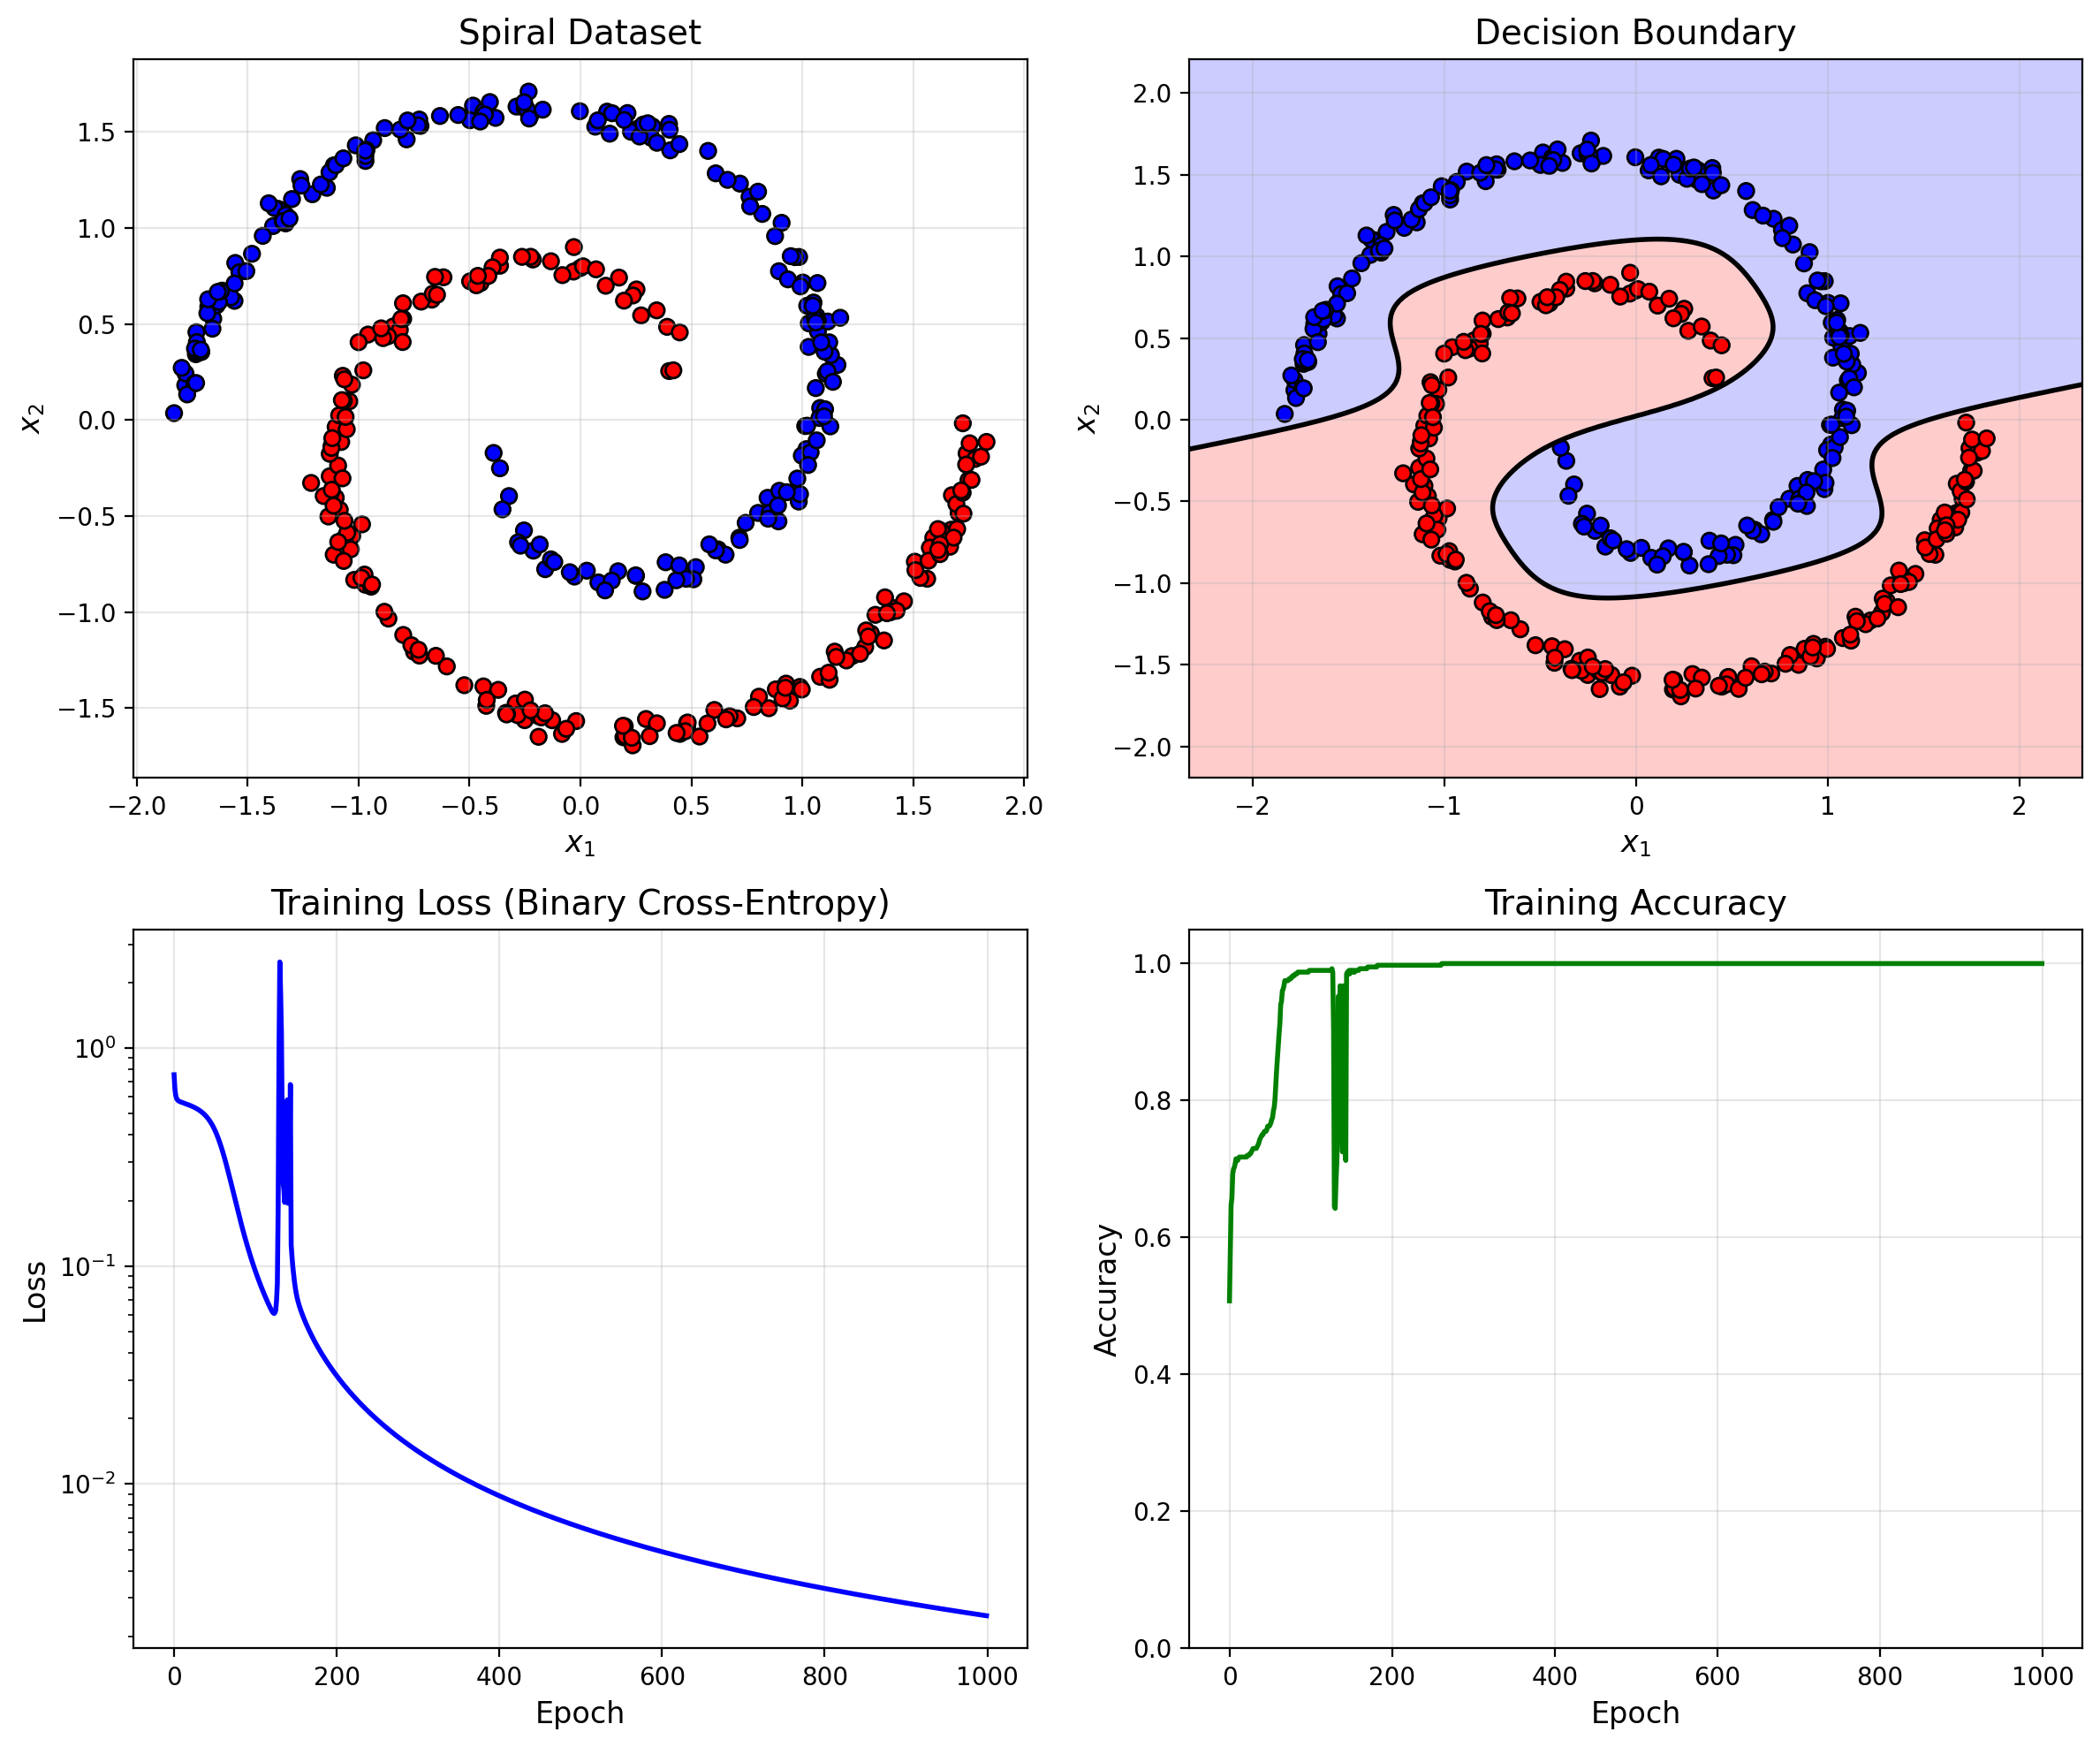


Plot saved to 'plot.png'


In [6]:
def plot_decision_boundary(nn, X, y, ax):
    """
    Plot the decision boundary learned by the network.
    """
    # Create mesh grid
    margin = 0.5
    x_min, x_max = X[0, :].min() - margin, X[0, :].max() + margin
    y_min, y_max = X[1, :].min() - margin, X[1, :].max() + margin
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    
    # Predict on mesh
    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    Z = nn.forward(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap=cmap_light, alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=2)
    
    # Plot data points
    scatter = ax.scatter(
        X[0, :], X[1, :],
        c=y.ravel(),
        cmap=ListedColormap(['#FF0000', '#0000FF']),
        edgecolors='k',
        s=40
    )
    
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_title('Decision Boundary', fontsize=14)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Training data
ax1 = axes[0, 0]
colors = ['#FF0000' if yi == 0 else '#0000FF' for yi in y.ravel()]
ax1.scatter(X[0, :], X[1, :], c=colors, edgecolors='k', s=40)
ax1.set_xlabel('$x_1$', fontsize=12)
ax1.set_ylabel('$x_2$', fontsize=12)
ax1.set_title('Spiral Dataset', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Decision boundary
ax2 = axes[0, 1]
plot_decision_boundary(nn, X, y, ax2)
ax2.grid(True, alpha=0.3)

# Plot 3: Loss curve
ax3 = axes[1, 0]
ax3.plot(nn.loss_history, 'b-', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12)
ax3.set_title('Training Loss (Binary Cross-Entropy)', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Accuracy curve
ax4 = axes[1, 1]
ax4.plot(nn.accuracy_history, 'g-', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Accuracy', fontsize=12)
ax4.set_title('Training Accuracy', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('backpropagation_from_scratch_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis of Gradient Flow

Let's examine the gradient magnitudes during training to understand the dynamics of backpropagation.

In [7]:
# Compute current gradients for analysis
_ = nn.forward(X)
dW, db = nn.backward(X, y)

print("Gradient Analysis")
print("=" * 50)
for i, (w, dw) in enumerate(zip(nn.weights, dW)):
    print(f"\nLayer {i+1}:")
    print(f"  Weight shape: {w.shape}")
    print(f"  Weight magnitude: {np.linalg.norm(w):.4f}")
    print(f"  Gradient magnitude: {np.linalg.norm(dw):.6f}")
    print(f"  Gradient/Weight ratio: {np.linalg.norm(dw)/np.linalg.norm(w):.6f}")

Gradient Analysis

Layer 1:
  Weight shape: (16, 2)
  Weight magnitude: 5.5906
  Gradient magnitude: 0.000599
  Gradient/Weight ratio: 0.000107

Layer 2:
  Weight shape: (8, 16)
  Weight magnitude: 6.6835
  Gradient magnitude: 0.001579
  Gradient/Weight ratio: 0.000236

Layer 3:
  Weight shape: (1, 8)
  Weight magnitude: 6.0204
  Gradient magnitude: 0.001867
  Gradient/Weight ratio: 0.000310


## Summary

This notebook demonstrated:

1. **Mathematical foundations** of neural networks and backpropagation using the chain rule

2. **Forward propagation**: Computing $\mathbf{z}^{(l)} = \mathbf{W}^{(l)} \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}$ and $\mathbf{a}^{(l)} = \sigma(\mathbf{z}^{(l)})$

3. **Backpropagation**: Computing gradients via $\boldsymbol{\delta}^{(l)} = \left( (\mathbf{W}^{(l+1)})^T \boldsymbol{\delta}^{(l+1)} \right) \odot \sigma'(\mathbf{z}^{(l)})$

4. **Gradient descent**: Updating parameters with $\mathbf{W} \leftarrow \mathbf{W} - \eta \nabla_W \mathcal{L}$

The network successfully learned to classify the nonlinear spiral dataset, demonstrating the power of multi-layer networks trained with backpropagation to learn complex decision boundaries.

### Key Insights

- **Vanishing gradients**: Deeper layers may receive smaller gradient signals, especially with sigmoid/tanh activations
- **Weight initialization**: Proper scaling (He/Xavier) prevents saturation and ensures healthy gradient flow
- **Learning rate**: Too high causes divergence; too low causes slow convergence
- **Architecture**: More neurons/layers can model more complex boundaries but risk overfitting